# DCGAN Implementation

Implementation of the (vanilla) Deep Convolutional Generative Adversarial Network defined by <a href="https://arxiv.org/pdf/1511.06434.pdf">Radford, Metz, and Chintala (2016)</a>.  Testing is done on the <a href="https://www.cs.toronto.edu/~kriz/cifar.html">CIFAR-10</a> benchmark image dataset, stored in pickled format in the `data/` directory.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from collections import OrderedDict

## Load CIFAR Data

In [129]:
# Helper functions to convert CIFAR-10 to Pytorch Dataset

def unpickle(file):
    import pickle
    with open(file, 'rb') as in_file:
        pickle_dict = pickle.load(in_file, encoding='bytes')
    return pickle_dict


def read_data(file_name):
    """Given path to CIFAR data batch, returns raw X, y tensors."""
    
    batch_dict = unpickle(file_name)
    X_raw = torch.tensor(batch_dict[b'data'])
    y_raw = torch.tensor(batch_dict[b'labels']).long()
    return X_raw, y_raw


def shape_image(X):
    """Reshapes raw data tensor to nn.module-compatible RGB image"""
    
    # Each row of X_raw contains RGB color channels concatenated in row-major order
    # Need to first split channels into dim 1 on tensor, then shape dim 2/3 into image
    image_size = 32*32
    X = torch.split(X.unsqueeze(dim=1), image_size, dim=2)
    X = torch.cat(X, dim=1)
    X = X.view(-1, 3, 32, 32)   # (N, channels, pixel rows, pixel cols)
    return X


def normalize(X, a=-1, b=1):
    """Normalizes data tensor to [a, b] using min-max scaling."""
    
    data_min = torch.min(X).float().item()
    data_max = torch.max(X).float().item()
    assert a < b, "Rescaled range [a, b] must have a < b"
    
    # First scale to [0, 1], then rescale to [a, b]
    X = (X - data_min) / (data_max - data_min)
    X = (X * (b - a)) + a  
    return X


class CIFARDataset(torch.utils.data.Dataset):
    """Custom Dataset class which preprocesses and stores datasets
       from CIFAR batch files.  Works for CIFAR-10 and CIFAR-100."""
    
    def __init__(self, file_list):
        # Get list of (X, y) tuples, concatenate corresponding tensors
        combined_list = [read_data(file_name) for file_name in file_list]
        X_list, y_list = list(zip(*combined_list))
        X = torch.cat(X_list, dim=0)
        y = torch.cat(y_list, dim=0)
        
        self.data = normalize(shape_image(X))
        self.labels = y
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        # Generates an (X, y) pair at given index
        return self.data[index], self.labels[index]
    
    def cuda(self):
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
            self.data = self.data.to(device)
            self.labels = self.labels.to(device)
            
    def cpu(self):
        self.data = self.data.cpu()
        self.labels = self.labels.cpu()

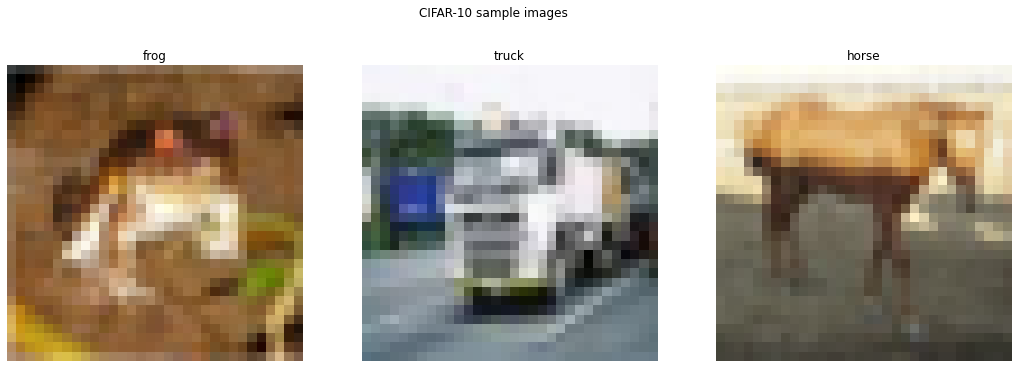

In [130]:
train_set = CIFARDataset([f"data/data_batch_{n}" for n in range(1, 6)])
test_set = CIFARDataset(["data/test_batch"])
cifar_meta = unpickle("data/batches.meta")

# Visualize a few random examples
def plot_image(x, ax):
    """Helper to scale and plot output from ImageDataset."""
    image = (x.squeeze().permute(1, 2, 0) + 1) / 2
    ax.imshow(image.clone().cpu().detach())
    ax.axis("off")
    
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):
    X, y = train_set[i*1000]
    plot_image(X, ax[i])
    ax[i].set_title(cifar_meta[b'label_names'][y.item()].decode('ascii'))
plt.suptitle("CIFAR-10 sample images")
plt.show()

## DCGAN Architecture

In [190]:
# Define architecture for vanilla generator and discriminator

class DCGenerator(nn.Module):
    """Deep convolutional generator which maps latent noise vector -> (32,32) RGB-channel image.
       The latent space input z is projected and convolved with many feature maps.
       Subsequent layers use only fractional-strided convolutions (no pooling).
       All hidden layers use ReLU activation, and output layer uses tanh."""
    
    def __init__(self, z_len=100):
        
        super(DCGenerator, self).__init__()
        self.z_len = z_len
        
        # Project z to volume of initial 3d tensor, then reshape
        self.project_weights = nn.Linear(z_len, 4 * 4 * 256)
        self.in_layer = lambda z: \
            torch.relu(self.project_weights(z).view(-1, 256, 4, 4))
        
        # Then layer transpose convolutions 
        # Choose kernel_size, stride, dilation to double height/width for each layer
        # Must also use batch normalization after most layers 
        self.conv_layers = nn.Sequential(OrderedDict([
            ("norm1", nn.BatchNorm2d(256)),
            ("conv1", nn.ConvTranspose2d(256, 128, 5)),
            ("relu1", nn.ReLU()),
            ("norm2", nn.BatchNorm2d(128)),
            ("conv2", nn.ConvTranspose2d(128, 64, 5)),
            ("relu2", nn.ReLU()),
            ("norm3", nn.BatchNorm2d(64)),
            ("conv3", nn.ConvTranspose2d(64, 32, 5)),
            ("relu3", nn.ReLU()),
            ("norm4", nn.BatchNorm2d(32)),
            ("conv4", nn.ConvTranspose2d(32, 3, 2, 2)),
            ("tanh", nn.Tanh())
        ]))
    
    def forward(self, z):
        return self.conv_layers(self.in_layer(z))


class DCDiscriminator(nn.Module):
    """Deep convolutional discriminator which maps (32,32) RGB-channel image -> [0, 1].
       The image is passed through several convolutional layers (again, no pooling).
       All hidden layers use LeakyReLU activation, and output layer uses sigmoid."""
    
    def __init__(self, leak_slope=0.02):
        
        super(DCDiscriminator, self).__init__()
        
        # Just reverse the convolutional layers from the Generator
        self.conv_layers = nn.Sequential(OrderedDict([
            ("conv1", nn.Conv2d(3, 32, 2, 2)),
            ("leak1", nn.LeakyReLU(leak_slope)),
            ("norm2", nn.BatchNorm2d(32)),
            ("conv2", nn.Conv2d(32, 64, 5)),
            ("leak2", nn.LeakyReLU(leak_slope)),
            ("norm3", nn.BatchNorm2d(64)),
            #("conv3", nn.Conv2d(64, 128, 5)),
            #("leak3", nn.LeakyReLU(leak_slope)),
            #("norm4", nn.BatchNorm2d(128)),
            #("conv4", nn.Conv2d(128, 256, 5)),
            #("leak4", nn.LeakyReLU(leak_slope)),
            #("norm5", nn.BatchNorm2d(256))
        ]))
        
        # Flatten and feed into sigmoid activation
        self.flatten_weights = nn.Linear(12 * 12 * 64, 1)
        self.out_layer = lambda maps: \
            torch.sigmoid(self.flatten_weights(maps.view(-1, 12 * 12 * 64)))
        
    def forward(self, x):
        return self.out_layer(self.conv_layers(x))

In [188]:
z = torch.randn(1, 100)
gen = DCGenerator()
dis = DCDiscriminator()
dis(gen(z))

tensor([[0.7454]], grad_fn=<SigmoidBackward>)

## DCGAN Training

The training is done using the minimax game described in the original GAN paper by <a href="https://arxiv.org/pdf/1406.2661.pdf">Goodfellow, et al (2014)</a>.  The choice of optimizer and batch size are specific to the DCGAN architecture.

In [191]:
# Functions to train built models and evaluate convergence

def jensen_shannon(which_model='full'):
    """Returns a function to compute an empirical estimate of the Jensen-Shannon
       divergence between the true data-generating distribution P_real and
       the generated distribution P_model over parallel batches x_real and x_model.
       
       This metric is optimized by a minimax operation, first maximizing over the
       discriminator weights, then minimizing over the generator weights.
       
       Returns:
       - if which_model = 'dis': returns function (D(x_model), D(x_real)) -> scalar
       - if which_model = 'gen': returns function (D(x_model)) -> scalar
         Both functions are returned in the form of minimization problems.
       - if which_model = 'full': returns non-negative version of 'dis' function.
         Use this version to calculate divergence after an epoch."""
    
    if which_model == 'dis':
        return lambda dis_model, dis_real: \
            -torch.mean(torch.log(dis_real) + torch.log(1 - dis_model))
        
    elif which_model == 'gen':
        # If generated samples are rejected easily, log(1 - D(x_model)) saturates
        # (stays close to 0), so use an approximation to improve early training
        return lambda dis_model: \
            -torch.mean(torch.log(dis_model))
    
    elif which_model == 'full':
        return lambda dis_model, dis_real: \
            torch.mean(torch.log(dis_real) + torch.log(1 - dis_model))
    
    else:
        raise ValueError("Argument `which_model` is not a valid value")

        
def train_DCGAN(gen, dis, train_set, test_set,
                num_epochs=100, dg_ratio=1, batch_size=1000,
                use_cuda=True):
    """Simultaneously trains generator and discriminator using minimax optimization of
       Jensen-Shannon divergence between discriminator performance on x_real vs. x_model.
       Uses ADAM optimizer for both networks, using params defined in DCGAN paper.
       Latent codes Z are drawn from a uniform prior.
       
       Parameters
       - num_epochs: the number of training epochs over the dataset
       - dg_ratio: the ratio of discriminator batches to generator batches
       - batch_size: the train_set batch size passed into discriminator
                     (for each real batch, an equal-sized batch is generated by generator)
    """
    
    # Move to GPU if possible; batches get moved as needed to save on memory
    device = "cuda:0" if use_cuda and torch.cuda.is_available() else "cpu"
    
    criterion = jensen_shannon()
    criterion_dis = jensen_shannon("dis")
    criterion_gen = jensen_shannon("gen")
    optimizer_dis = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_gen = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                         pin_memory=True, num_workers=0)
    # Keep a global count of how many discriminator steps happen per generator step
    # because dg_ratio may not divide evenly into batch_size
    dis_count = 0
    for epoch in range(num_epochs):
        #print(f"EPOCH {epoch+1}")
        
        for X, y in loader:
            # Discriminator trains each batch
            z = torch.randn((X.shape[0], gen.z_len)).to(device)
            X = X.clone().to(device, non_blocking=True)
            optimizer_dis.zero_grad()
            loss_dis = criterion_dis(dis(gen(z)), dis(X))
            loss_dis.backward()
            #rint(f"- dis input grad = {torch.norm(dis.flatten_weights.weight)}")
            optimizer_dis.step()
            dis_count += 1
            
            # Generator trains if enough discriminator passes have gone through
            if dis_count == dg_ratio:
                z = torch.randn((batch_size, gen.z_len)).to(device)
                optimizer_gen.zero_grad()
                loss_gen = criterion_gen(dis(gen(z)))
                loss_gen.backward()
                #print(f"- gen input grad = {torch.norm(gen.project_weights.weight)}")
                optimizer_gen.step()
                dis_count = 0
        
        # Evaluate how the model is performing on test set after a full epoch
        print(f"- EPOCH {epoch+1}:" +
              f"\n  discriminator loss = {loss_dis}" +
              f"\n      generator loss = {loss_gen}" +
              "\n----------------------------------")

In [192]:
torch.cuda.empty_cache()
gen = DCGenerator().cuda()
dis = DCDiscriminator().cuda()
train_set = CIFARDataset([f"data/data_batch_{n}" for n in range(1, 2)])
test_set = CIFARDataset(["data/test_batch"])

%time train_DCGAN(gen, dis, train_set, test_set, num_epochs=50, batch_size=128, use_cuda=True)

- EPOCH 1:
  discriminator loss = 1.248457431793213
      generator loss = 2.264566659927368
----------------------------------
- EPOCH 2:
  discriminator loss = 1.623605728149414
      generator loss = 1.8340059518814087
----------------------------------
- EPOCH 3:
  discriminator loss = 1.060103416442871
      generator loss = 1.7115449905395508
----------------------------------
- EPOCH 4:
  discriminator loss = 1.5291211605072021
      generator loss = 1.8060563802719116
----------------------------------
- EPOCH 5:
  discriminator loss = 1.5480930805206299
      generator loss = 1.5654215812683105
----------------------------------
- EPOCH 6:
  discriminator loss = 1.1287531852722168
      generator loss = 1.9726754426956177
----------------------------------
- EPOCH 7:
  discriminator loss = 1.1477530002593994
      generator loss = 2.085353374481201
----------------------------------
- EPOCH 8:
  discriminator loss = 0.6257020235061646
      generator loss = 2.1469199657440186


tensor([[0.0027],
        [0.0025],
        [0.0033],
        [0.0028],
        [0.0023],
        [0.0030],
        [0.0021],
        [0.0031],
        [0.0021],
        [0.0027]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9989],
        [0.9999],
        [1.0000],
        [1.0000],
        [0.9989]], device='cuda:0', grad_fn=<SigmoidBackward>)


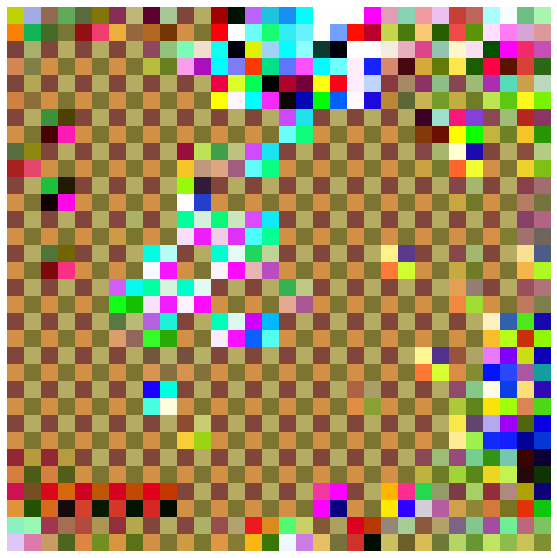

In [196]:
z = torch.rand(10, 100).cuda()
fig, ax = plt.subplots(figsize=(10, 10))
plot_image(gen(z)[1], ax)

print(dis(gen(z)))
print(dis(train_set[:10][0].cuda()))